In [0]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = r'/drive/My Drive/apple'
width=256
height=256
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []

In [0]:
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
       
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy']


In [0]:
np_image_list = np.array(image_list, dtype=np.uint8) / 255

In [0]:
x_test,y_test =(np_image_list, image_labels)

In [0]:
x_test.shape

(506, 256, 256, 3)

In [0]:
from keras.models import load_model
model = load_model("/drive/My Drive/Colab Notebooks/segment_apple_model.hdf5")
print("[INFO]model loaded")





[INFO]model loaded


In [0]:
scores=model.evaluate(x_test,y_test)
print(f"Test Accuracy: {scores[1]*100}")

506/506 [==============================] - 30s 60ms/step
Test Accuracy: 99.01185770750988


In [0]:
import sklearn.metrics as metrics
preds= np.round(model.predict(x_test),0)
class_lables=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust',
 'Apple___healthy']
c_m =metrics.classification_report(y_test,preds,target_names=class_lables)
print(c_m)

                          precision    recall  f1-score   support

      Apple___Apple_scab       0.98      0.99      0.99       126
       Apple___Black_rot       1.00      0.98      0.99       125
Apple___Cedar_apple_rust       1.00      1.00      1.00        55
         Apple___healthy       0.99      0.99      0.99       200

               micro avg       0.99      0.99      0.99       506
               macro avg       0.99      0.99      0.99       506
            weighted avg       0.99      0.99      0.99       506
             samples avg       0.99      0.99      0.99       506



In [0]:
import pandas as pd
from sklearn.metrics import confusion_matrix
categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):

 
   if normalize:
     cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
   else:
     print("Confusion matrix, without normalization")
 

 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

Normalized confusion matrix


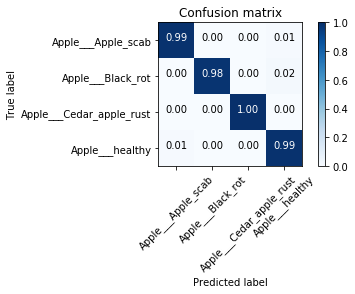

In [0]:
import itertools
plot_confusion_matrix(confusion_matrix,['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust',
 'Apple___healthy'],normalize=True)

In [0]:
from keras.preprocessing import image

test_image = np.expand_dims(x_test, axis=0)

test_image = test_image.reshape(-1,256,256,3)   
result = model.predict(test_image, batch_size=10)
print(result)


[[6.2426682e-11 1.0000000e+00 9.7903714e-14 3.0231679e-13]
 [1.0515426e-12 9.9999988e-01 4.4248334e-14 9.9020269e-08]
 [2.1733488e-09 1.0000000e+00 1.0514359e-13 2.2696975e-12]
 ...
 [6.7220016e-19 1.3817258e-16 1.0000000e+00 3.6444283e-19]
 [4.0286627e-19 9.9753268e-13 1.0000000e+00 3.4793805e-20]
 [2.0593451e-10 1.8209333e-13 1.0000000e+00 4.6327157e-13]]


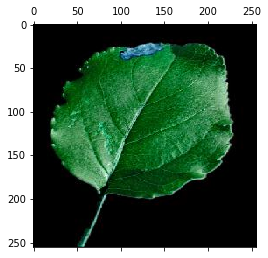

In [0]:
plt.matshow(x_test[10])

In [0]:
from keras.preprocessing import image

test_image = np.expand_dims(x_test, axis=0)

test_image = test_image.reshape(-1,256,256,3)   
result = model.predict(test_image, batch_size=1)
print(result[10])
max_prob=np.argmax(result[10])
print(max_prob)

[1.6867305e-09 1.0000000e+00 7.7129588e-19 5.1111464e-08]
1


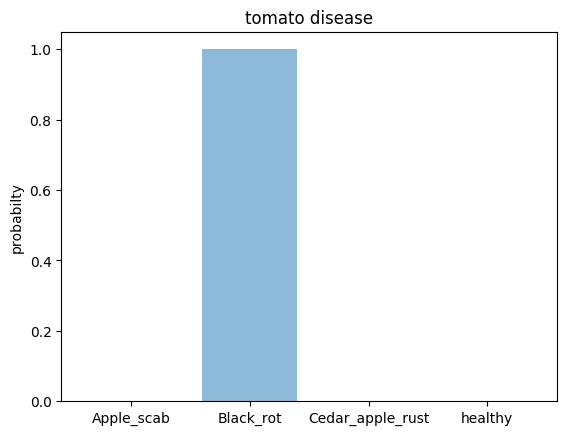

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Apple_scab','Black_rot','Cedar_apple_rust',
 'healthy')
y_pos = np.arange(len(objects))
performance = result[10]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('probabilty')
plt.title('apple disease')

plt.show()

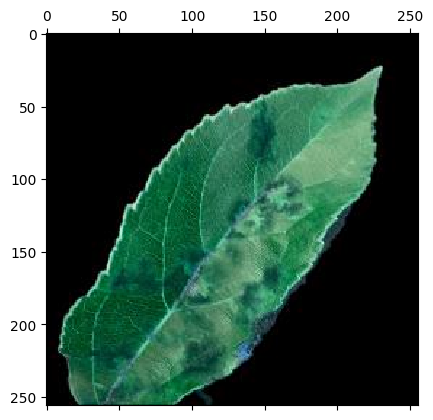

In [0]:
plt.matshow(x_test[400])

In [0]:
from keras.preprocessing import image

test_image = np.expand_dims(x_test, axis=0)

test_image = test_image.reshape(-1,256,256,3)   
result = model.predict(test_image, batch_size=1)
print(result[400])
max_prob=np.argmax(result[400])
print(max_prob)

[9.9999976e-01 1.0085459e-09 3.3271800e-08 1.9013403e-07]
0


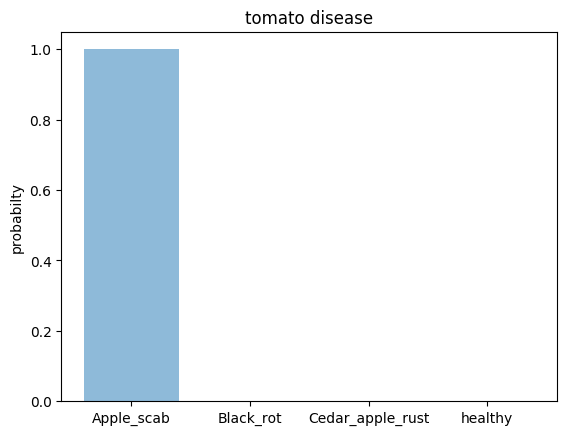

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Apple_scab','Black_rot','Cedar_apple_rust',
 'healthy')
y_pos = np.arange(len(objects))
performance = result[400]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('probabilty')
plt.title('apple disease')

plt.show()